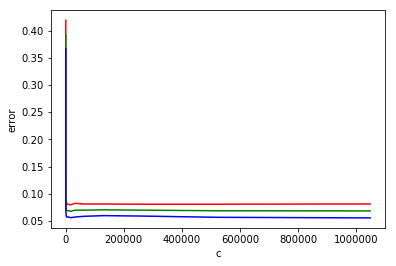

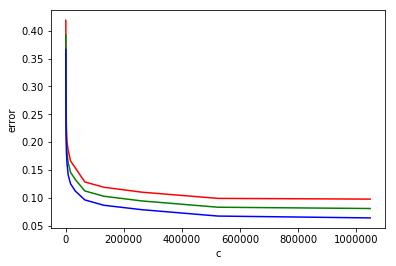

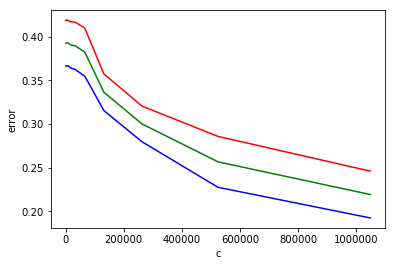

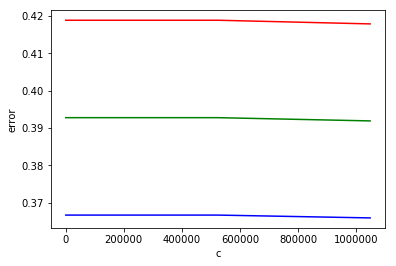

0.0678260869565 14 1
[688, 1473, 2734, 2725]


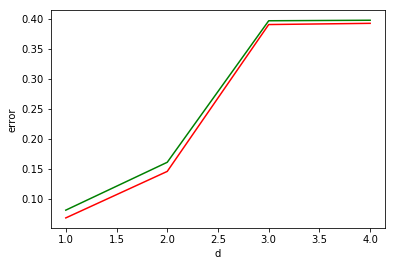

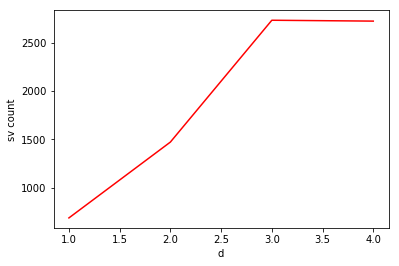

In [1]:
from svmutil import *
import csv
import subprocess
import math
import sys
import matplotlib.pyplot as plt 

def csv_2_libsvm(input_filename, train_filename, test_filename, train_size):
    with open(input_filename, 'r') as csvfile, open(train_filename, 'w') as train_output, open(test_filename, 'w') as test_output:
        reader = csv.reader(csvfile, delimiter=',')
        train_writer = csv.writer(train_output, delimiter=' ', lineterminator='\n')
        test_writer = csv.writer(test_output, delimiter=' ', lineterminator='\n')
        line_num = 0
        for line in reader:
            output_row = []
            output_row.append(line[-1])
            for idx, attribute in enumerate(line[:-1]):
                output_row.append(str(idx + 1) + ":" + attribute)
            if line_num < train_size:
                train_writer.writerow(output_row)
            else:
                test_writer.writerow(output_row)
            line_num += 1
            
def scale_data(train_filename, test_filename):
    subprocess.call(['svm-scale.exe', '-l', '0', '-u', '1', '-s', train_filename + '.params', train_filename, 
                     '>', train_filename + '.scale'], shell=True)
    subprocess.call(['svm-scale.exe', '-r', train_filename + '.params', test_filename, 
                     '>', test_filename + '.scale'], shell=True)
            
def train(y, x, C, d):
    prob  = svm_problem(y, x)
    param = svm_parameter()
    param.kernel_type = POLY
    param.C = C
    param.degree = d
    return svm_train(prob, param)

def draw_c_err(x, y):
    plt.cla()
    plt.xlabel('c')
    plt.ylabel('error')
    plt.plot(x, [item[0] + item[1] for item in y], 'r')
    plt.plot(x, [item[0] for item in y], 'g')
    plt.plot(x, [item[0] - item[1] for item in y], 'b')
    plt.show()
    
def draw_d_err(x, val_err, test_err):
    plt.cla()
    plt.xlabel('d')
    plt.ylabel('error')
    plt.plot(x, val_err, 'r')
    plt.plot(x, test_err, 'g')
    plt.show()
    
def draw_d_sv(x, sv):
    plt.cla()
    plt.xlabel('d')
    plt.ylabel('sv count')
    plt.plot(x, sv, 'r')
    plt.show()

def k_fold(x, y, k, c, d):
    errors = []
    k_fold_size = len(x) / k
    for k_idx in xrange(k):        
        x_train = x[:k_idx * k_fold_size] + x[(k_idx + 1) * k_fold_size:]
        y_train = y[:k_idx * k_fold_size] +y[(k_idx + 1) * k_fold_size:]
        
        x_validation = x[k_idx * k_fold_size:(k_idx + 1) * k_fold_size]
        y_validation = y[k_idx * k_fold_size:(k_idx + 1) * k_fold_size]
        
        m = train(y_train, x_train, c, d)
        p_label, p_acc, p_val = svm_predict(y_validation, x_validation, m, '-q')
            
        errors.append(p_acc[1])
            
    m = train(y, x, c, d)
    p_label, p_acc, p_val = svm_predict(y, x, m, '-q')
    avg_err = sum(errors) / k
    deviation = math.sqrt(sum([(err - avg_err) ** 2 for err in errors]) / k)
    return avg_err, deviation, p_acc[1]    

train_size = 3450
csv_2_libsvm('spambase.data.shuffled.txt', 'train.libsvm', 'test.libsvm', train_size)
scale_data('train.libsvm', 'test.libsvm')

y, x = svm_read_problem('train.libsvm.scale')
y_test, x_test = svm_read_problem('test.libsvm.scale')

k_c = 20
k_fold_size = 10

best_err = sys.maxint
best_c = 0
best_d = 0

for d in xrange(1, 5):   
    res_c = []
    res_err = []
    for k in xrange(-k_c, k_c + 1):
        avg_err, deviation, er = k_fold(x, y, k_fold_size, 2 ** k, d)
        
        res_c.append(2 ** k)
        res_err.append((avg_err, deviation))
        
        if (avg_err < best_err):
            best_err = avg_err
            best_c = k
            best_d = d
            
    draw_c_err(res_c, res_err)    
            
print best_err, best_c, best_d

res_d = []
res_err = []
test_err = []
res_sv = []
for i in xrange(1, 5):
    avg_err, deviation, er = k_fold(x, y, k_fold_size, 2 ** best_c, i)
    
    m = train(y, x, 2 ** best_c, i)
    p_label, p_acc, p_val = svm_predict(y_test, x_test, m, '-q')
    
    res_err.append(avg_err)
    test_err.append(p_acc[1])
    res_d.append(i)
    
    res_sv.append(len(m.get_SV()))
    
print res_sv
draw_d_err(res_d, res_err, test_err) 
draw_d_sv(res_d, res_sv)